In [ ]:
data_path='/content/Data.csv'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Bidirectional, Dense, Dropout, GRU, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


# Load data
df = pd.read_csv(data_path, low_memory=False)

# Drop unnecessary columns
df = df.drop(['Timestamp', 'X Value', 'Y Value', 'Z Value'] + [col for col in df.columns if 'Quality' in col], axis=1)

# Data cleaning
df.columns = [col.replace(' Value', '') for col in df.columns]
df.replace('-', np.nan, inplace=True)
#df = df.fillna(df.mean(numeric_only=True))
df = df.dropna()

df.iloc[:, :-3] = df.iloc[:, :-3].astype(float)

# Bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

# Sampling rate
fs = 128

# Apply bandpass filter (1-30 Hz)
eeg_data = df.drop(['run', 'usernum', 'truth'], axis=1)
eeg_data_filtered = bandpass_filter(eeg_data.values, lowcut=1.0, highcut=30.0, fs=fs)
df[eeg_data.columns] = eeg_data_filtered

# Create samples with smaller window size and greater overlap
window_size = 64  # Greater window size
overlap = 32      # Greater overlap

def create_samples(df, window_size, overlap):
    samples = []
    labels = []
    step = window_size - overlap

    for run in df['run'].unique():
        run_data = df[df['run'] == run]
        for i in range(0, len(run_data) - window_size + 1, step):
            window = run_data.iloc[i:i + window_size]
            if len(window) == window_size:
                samples.append(window.drop(['run', 'usernum', 'truth'], axis=1).values)
                labels.append(window['truth'].iloc[0])

    return np.array(samples), np.array(labels)

samples, labels = create_samples(df, window_size, overlap)

# Balance dataset by undersampling
true_indices = np.where(labels == 1)[0]  # Positive class
lie_indices = np.where(labels == 0)[0]   # Negative class

# Ensure both classes have the same number of samples
np.random.seed(42)
if len(true_indices) > len(lie_indices):
    remove_indices = np.random.choice(true_indices, size=len(true_indices) - len(lie_indices), replace=False)
    balanced_true_indices = np.setdiff1d(true_indices, remove_indices)
    balanced_lie_indices = lie_indices
else:
    remove_indices = np.random.choice(lie_indices, size=len(lie_indices) - len(true_indices), replace=False)
    balanced_lie_indices = np.setdiff1d(lie_indices, remove_indices)
    balanced_true_indices = true_indices

# Combine the balanced indices
balanced_indices = np.concatenate((balanced_true_indices, balanced_lie_indices))
np.random.shuffle(balanced_indices)

# Create the balanced dataset
balanced_samples = samples[balanced_indices]
balanced_labels = labels[balanced_indices]

# Data augmentation: Adding Gaussian noise to the EEG data
def augment_data(samples, noise_factor=0.02):
    augmented_samples = []
    for sample in samples:
        noise = np.random.normal(0, noise_factor, sample.shape)
        augmented_sample = sample + noise
        augmented_samples.append(augmented_sample)
    return np.array(augmented_samples)

# Augment the balanced dataset
augmented_samples = augment_data(balanced_samples)
augmented_labels = balanced_labels  # Use the same labels for augmented data

# Combine original and augmented data
combined_samples = np.concatenate([balanced_samples, augmented_samples])
combined_labels = np.concatenate([balanced_labels, augmented_labels])

# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(combined_samples, combined_labels, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Define the BiGRU model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Initialize empty lists to store the concatenated results
train_accuracies_concat = []
val_accuracies_concat = []
train_losses_concat = []
val_losses_concat = []

# K-Fold cross-validation and concatenation of histories
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
for train_index, val_index in kfold.split(X_train):
    print(f"Training fold {fold_no}...")

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model with the current fold
    history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_val_fold, y_val_fold),
                        epochs=100,
                        batch_size=64,
                        callbacks=[early_stopping],
                        verbose=1)

    # Concatenate the metrics (append them in sequence)
    train_accuracies_concat.extend(history.history['accuracy'])
    val_accuracies_concat.extend(history.history['val_accuracy'])
    train_losses_concat.extend(history.history['loss'])
    val_losses_concat.extend(history.history['val_loss'])

    fold_no += 1


# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("BiGRU Model Accuracy: {:.2f}%".format(accuracy * 100))

# Predictions and classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes))

Training fold 1...
Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5127 - loss: 0.7116 - val_accuracy: 0.5578 - val_loss: 0.6853
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5535 - loss: 0.6874 - val_accuracy: 0.5682 - val_loss: 0.6703
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5792 - loss: 0.6700 - val_accuracy: 0.6305 - val_loss: 0.6500
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6383 - loss: 0.6419 - val_accuracy: 0.6443 - val_loss: 0.6325
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6691 - loss: 0.6095 - val_accuracy: 0.6798 - val_loss: 0.5927
Epoch 6/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7303 - loss: 0.5485 - val_accuracy: 0.7239 - val_loss: 0.5343
Epoch 7/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7881 - loss: 0.4579 - val_accuracy: 0.7802 - val_loss: 0.4742
Epoch 8/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.83

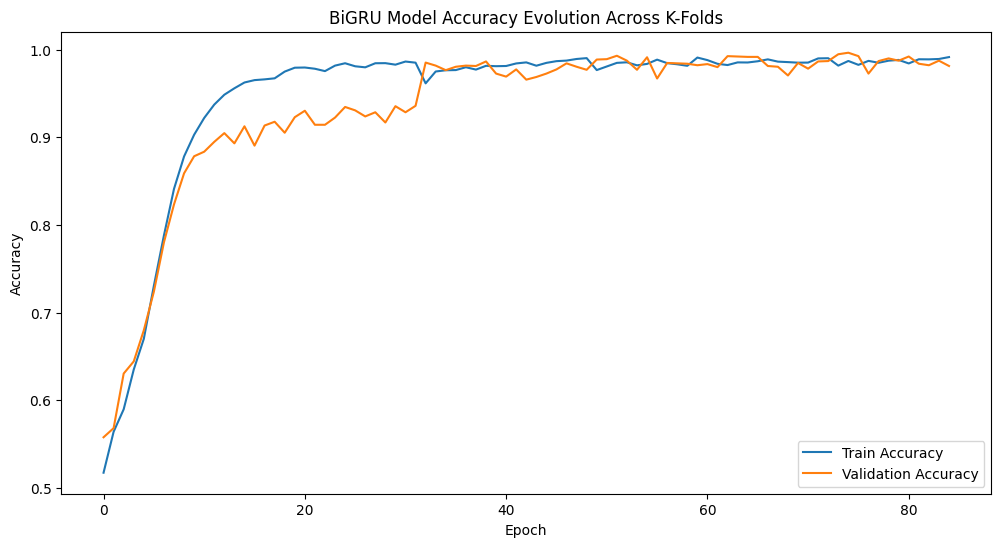

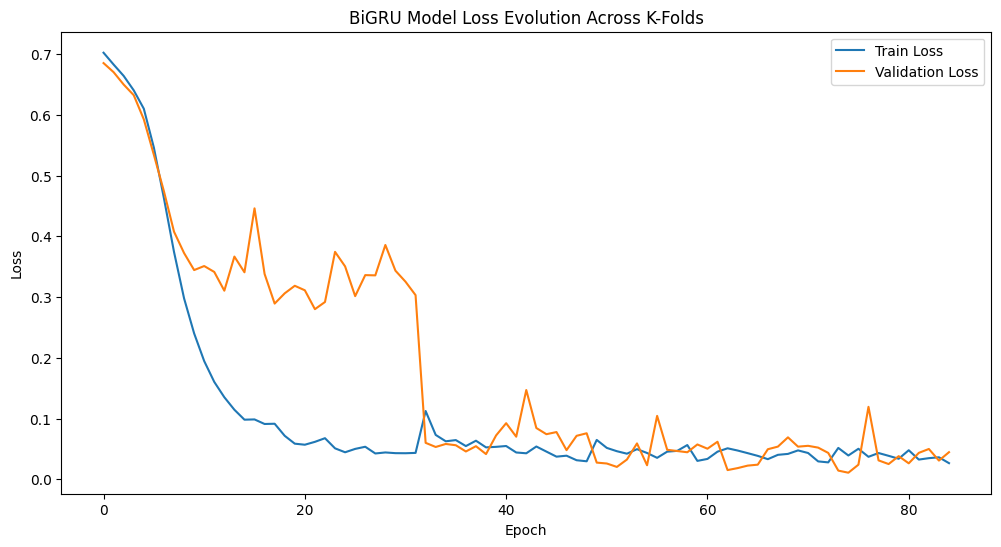

In [ ]:
# Plot accuracy evolution
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies_concat, label='Train Accuracy')
plt.plot(val_accuracies_concat, label='Validation Accuracy')
plt.title('BiGRU Model Accuracy Evolution Across K-Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss evolution
plt.figure(figsize=(12, 6))
plt.plot(train_losses_concat, label='Train Loss')
plt.plot(val_losses_concat, label='Validation Loss')
plt.title('BiGRU Model Loss Evolution Across K-Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

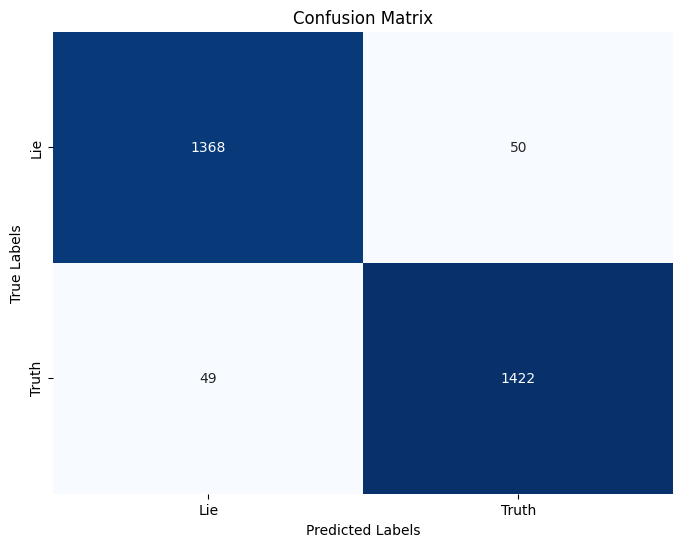

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert one-hot encoded labels back to class indices
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Lie", "Truth"], yticklabels=["Lie", "Truth"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
model.save_weights('BiGRU.weights.h5')
model.save('BiGRU.keras')